In [47]:
import pandas as pd
from plotly.offline import init_notebook_mode, iplot, iplot_mpl
import plotly.graph_objs as go
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (15, 7)
init_notebook_mode(connected=True)
colors = {
    'ndk': '#008894',
    'jvm': '#556DFF',
    
    'ndk_float': '#00C677',
    'ndk_short': '#008894',
    'jvm_float': '#CB43E1',
    'jvm_short': '#556DFF',

    'ndk_complex': '#00C677',
    'ndk_real': '#008894',
    'jvm_complex': '#CB43E1',
    'jvm_real': '#556DFF',

}
sns.set_palette(sns.color_palette(colors.values()))

convolution = pd.read_csv('data/convolution_benchmark_1565782392505.csv', index_col='env')
fft = pd.read_csv('data/fft_benchmark_1565782392505.csv', index_col='env')
conversion = pd.read_csv('data/conversion_benchmark_1565782392505.csv', header=None).set_index(0)

# Convolution benchmark

FIR filter was implemented from scratch in two versions - one working on floats and one using shorts. Kotlin implementation: 

```kotlin
class FIRFloat(private val coefs: FloatArray) {
    private val length: Int = coefs.size
    private val delayLine: FloatArray
    private var count = 0

    init {
        delayLine = FloatArray(length)
    }

    fun getOutputSample(inputSample: Float): Float {
        delayLine[count] = inputSample
        var result = 0.0F
        var index = count
        for (i in 0 until length) {
            result += coefs[i] * delayLine[index--]
            if (index < 0) index = length - 1
        }
        if (++count >= length) count = 0
        return result
    }
}
```

C++ implementation is analogous.

In [12]:
iplot({
    'data': [
        go.Scatter(**dict(
            x = convolution.T.index,
            y = convolution.T[env],
            mode = 'lines', # markers
            name = env.upper(),
            marker_color = colors[env]
        )) for env in ['jvm_float', 'jvm_short', 'ndk_float', 'ndk_short']
    ],
    'layout': go.Layout(title='Convolution full benchmark results', xaxis=dict(title='filter length'), yaxis=dict(title='samples / s'))
})

### JVM / NDK speed ratio

In [13]:
floats = convolution.T['jvm_float'] / convolution.T['ndk_float']
shorts = convolution.T['jvm_short'] / convolution.T['ndk_short']

In [14]:
floats.describe()

count    100.000000
mean       2.667887
std        0.517203
min        1.500000
25%        2.330543
50%        2.376907
75%        3.060728
max        4.074700
dtype: float64

In [15]:
shorts.describe()

count    100.000000
mean       2.862432
std        0.334165
min        1.500000
25%        2.731795
50%        2.792564
75%        2.924134
max        4.166667
dtype: float64

''

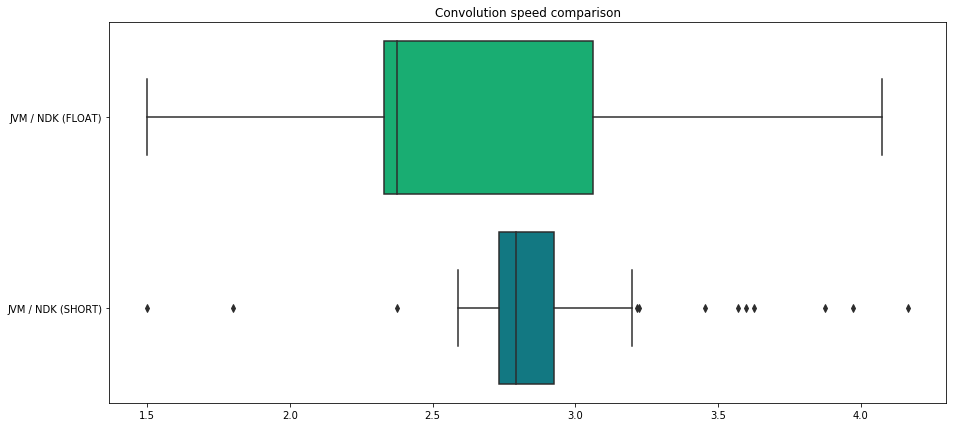

In [22]:
y = ['JVM / NDK (FLOAT)'] * len(floats) + ['JVM / NDK (SHORT)'] * len(shorts)
sns.boxplot(
    x=pd.concat([floats, shorts]),
    y=y
).set_title('Convolution speed comparison')
''

## Summary

For some reason JVM implementation was much faster. On average floats JVM implementation was 2.7 times faster than NDK. JVM implementation using shorts was ~2.9 times faster than C++ shorts implementation.

# FFT

JVM version uses [JTransforms](https://github.com/wendykierp/JTransforms) library, which is the most popular pure-java FFT library I could find. It also has an opinion of being quite fast.

NDK version uses [FFTW](http://www.fftw.org/) library which is a de-facto standard for doing FFT in C/C++. It was cross-compiled for Android using [this repository](https://github.com/Lauszus/fftw3-android).

In [17]:
iplot({
    'data': [
        go.Scatter(**dict(
            x = fft.T.index,
            y = fft.T[env],
            mode = 'lines', # markers
            name = env.upper(),
            marker_color = colors[env]
        )) for env in ['jvm_complex', 'jvm_real', 'ndk_complex', 'ndk_real']
    ],
    'layout': go.Layout(title='FFT full benchmark results', xaxis=dict(title='FFT width'), yaxis=dict(title='FFTs / s'))
})

### NDK / JVM speed ratio

In [23]:
complex = fft.T['ndk_complex'] / fft.T['jvm_complex']
real = fft.T['ndk_real'] / fft.T['jvm_real']
y = ['NDK / JVM (COMPLEX)'] * len(complex) + ['NDK / JVM (REAL)'] * len(real)

In [24]:
complex.describe()

count    20.000000
mean      3.608689
std       4.411019
min       1.360166
25%       1.424639
50%       1.760356
75%       2.831314
max      19.318841
dtype: float64

In [25]:
real.describe()

count    20.000000
mean      3.159399
std       2.189892
min       0.777754
25%       1.901084
50%       2.110978
75%       3.967487
max       9.748148
dtype: float64

''

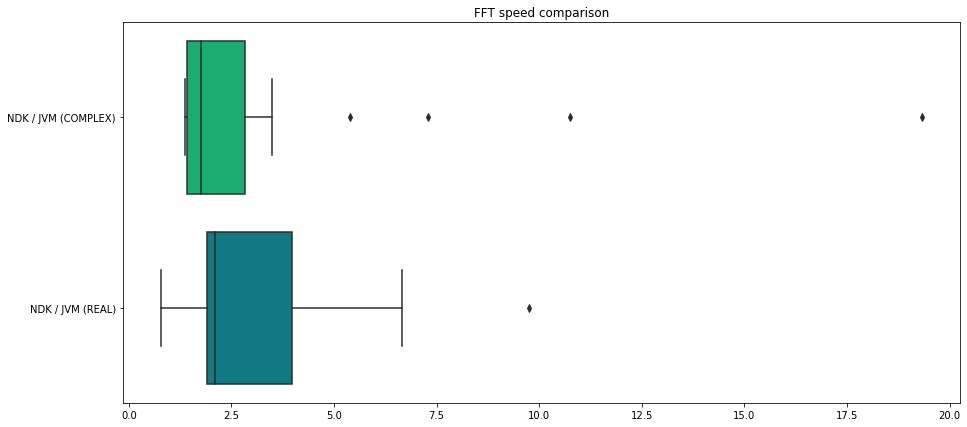

In [26]:
sns.boxplot(
    x=pd.concat([complex, real]),
    y=y
).set_title('FFT speed comparison')
''

## Summary

NDK implementation using complex numbers was on average 3.6 times faster than analogous implementation on JVM. On real numbers NDK implementation is ~3.2 times faster. Long right tail means there's a few outliers where NDK implementation was over 10 times faster.

# Type conversions

The following type conversions were benchmarked:

* short -> float: assuming short value has to be scaled down using a constant representing DAC dynamic range
* float -> short: assuming float value is normalized to <-1, 1> range and has to be scaled up by a constant representing DAC dynamic range
* short -> complex: assuming an array of shorts is in interleaved format where array[k] represent real parts and array[k+1] represent imaginary parts. In C++ std::complex class was used to construct complex objects. In kotlin popular apache math-commons library was used.

In [34]:
conversion_means = conversion.T.mean()

In [53]:
fig = iplot({
    'data': [
        go.Bar(
            x = ['short_float', 'float_short', 'short_complex'],
            y = [conversion_means[series] for series in [f'{env}_short_float', f'{env}_float_short', f'{env}_short_complex']],
            name = env.upper(),
            marker_color = colors[env]
        ) for env in ['jvm', 'ndk']
    ],
    'layout': go.Layout(barmode='group', yaxis=dict(title='conversions / s'))
})

### JVM / NDK speed ratio

In [56]:
short_float = conversion_means['jvm_short_float'] / conversion_means['ndk_short_float']
float_short = conversion_means['jvm_float_short'] / conversion_means['ndk_float_short']
short_complex = conversion_means['jvm_short_complex'] / conversion_means['ndk_short_complex']

short_float, float_short, short_complex

(2.144611134990965, 3.272701622568073, 0.20893299396111717)

## Summary

On average, JVM implementation was 2.1 times faster at short -> float conversion, 3.3 times faster at float -> short conversion and 5 times slower at short -> complex conversion.

# Gotchas

Benchmarking C++ and JVM code is tricky. Here's a few gotchas we found:

* JVM needs warm-up. The first run is often slower than the following runs.
* JVM JIT can eliminate a for loop alltogether in some cases
* Using simple arrays instead of std::vector in C++ gave us considerable speed boost (~40%).